In [1]:
from __future__ import unicode_literals

import sys, os
BIN = os.path.expanduser("../../")
sys.path.append(BIN)

import numpy as np
from scipy.constants import m_p, c, e, pi
import matplotlib.pyplot as plt
%matplotlib inline

import copy
import itertools

from test_tools import generate_objects, BunchTracker, track, compare_traces, compare_projections, Machine

from PyHEADTAIL_feedback.feedback import OneboxFeedback, Kicker, PickUp
from PyHEADTAIL_feedback.processors.multiplication import ChargeWeighter
from PyHEADTAIL_feedback.processors.linear_transform import Averager
from PyHEADTAIL_feedback.processors.misc import Bypass
from PyHEADTAIL_feedback.processors.register import Register, TurnDelay

np.random.seed(0)

PyHEADTAIL v(no git available to determine version)




In [2]:
""" 
    In this example a more complex feedback system, which is an ideal bunch feedback consisting of
    a separate pickup and a kicker is demonstrated. The details of the ideal bunch feedback can be found
    from the previous filr (001_ideal_feedbacks.ipynb).

"""

u' \n    In this example a more complex feedback system, which is an ideal bunch feedback consisting of\n    a separate pickup and a kicker is demonstrated. The details of the ideal bunch feedback can be found\n    from the previous filr (001_ideal_feedbacks.ipynb).\n\n'

In [3]:
# Basic parameters for the simulation
n_macroparticles = 10000
n_slices = 20
n_segments = 5
n_sigma_z = 3 

n_turns = 100

# Longitudinal motion of the bunch is not taken into account in this example.
machine = Machine(Q_s = 0.00000001)
# The longitudinal motion can be included to simulations by uncommenting the following line
# machine = Machine(Q_s = 0.0020443)

bunch_ref, slicer_ref,trans_map, long_map = generate_objects(machine, n_macroparticles,n_segments, 
                                                             n_slices,n_sigma_z)
bunch_unkicked = copy.deepcopy(bunch_ref)


In [4]:
# This creates an artificially kicked bunch, which will be damped by using different feedback systems

slice_set = bunch_ref.get_slices(slicer_ref, statistics=True)
p_idx = slice_set.particles_within_cuts
s_idx = slice_set.slice_index_of_particle.take(p_idx)

# random kicks
kick_x = 0.003*(-1.0+2*np.random.rand(n_slices))
kick_y = 0.003*(-1.0+2*np.random.rand(n_slices))

for p_id, s_id in itertools.izip(p_idx,s_idx):
    bunch_ref.x[p_id] += kick_x[s_id]
    bunch_ref.y[p_id] += kick_y[s_id]
    
bunch_init = copy.deepcopy(bunch_ref)
tracker_ref = BunchTracker(bunch_init)
maps_ref = [i for i in trans_map] + [long_map]
track(n_turns, bunch_init,maps_ref,tracker_ref)

In [5]:
# In the used code, the parameter 'gain' is determined as a fraction of the signal which is bypassed
# perfectly throught the signal processors

# There are two ways to set a gain value. If only one value is given, same value is used both in 
# horizontal and vertical planes. If two values are given, separed values (x,y) are used for horizontal and
# vertical planes.

feedback_gain = 0.1
# feedback_gain = (0.1,0.4)

# Parameters for the registers
delay = 1 
n_values = 3

In [6]:
# A reference feedback system, which is originally introduced in the file 001_ideal_feedbacks.ipynb:

bunch_OneBox_bunch = copy.deepcopy(bunch_ref)
tracker_OneBox_bunch = BunchTracker(bunch_OneBox_bunch)
slicer_OneBox_bunch = copy.deepcopy(slicer_ref)

processors_bunch_x = [
    ChargeWeighter(normalization = 'segment_average'),
    Averager()
]
processors_bunch_y = [
    ChargeWeighter(normalization = 'segment_average'),
    Averager()
]

feedback_map = OneboxFeedback(feedback_gain,slicer_OneBox_bunch,processors_bunch_x,processors_bunch_y,axis='displacement')
total_map_OneBox_bunch = [i for i in trans_map] + [long_map] + [feedback_map]

track(n_turns, bunch_OneBox_bunch,total_map_OneBox_bunch,tracker_OneBox_bunch)

In [7]:
bunch_register_example = copy.deepcopy(bunch_ref)
tracker_register_example = BunchTracker(bunch_register_example)
slicer_register_example = copy.deepcopy(slicer_ref)

# Before implementing a feedback system consisting of the separate pickup and kicker, a new signal processor must be 
# introduced; a register. Registers is a signal processors which can store and delay a signal in the units of turns. 
# In order to do that they are also able to rotate the signal in terms of betatron motion.
#
# At the moment of writing this example, three different types of registers have been implemented 
# (VectorSumRegister(...), CosineSumRegister(...) and HilbertPhaseShiftRegister(...)). They work
# exactly similarly as a part of the signal processor list, but they utilize different mathematical approaches for 
# betatron phase shift inside the processors
#
# HilbertPhaseShiftRegister is used in the examples for the demonstrating the use of a register 
# as a signal processor. At first, one turn delay is implemented by simply adding a register to the lists of signal
# processors
#
# Delay (in the units of turns) is given as an input parameter for the registers. The other required input parameters 
# for are a number of values stored to register (used for calculating the correct betatron phase for 
# the output signal), and a betatron tune of the machine for the studied plane.

processors_register_example_x = [
    ChargeWeighter(normalization = 'segment_average'),
    Averager(),
    TurnDelay(delay, machine.Q_x, n_values)
]
processors_register_example_y = [
    ChargeWeighter(normalization = 'segment_average'),
    Averager(),
    TurnDelay(delay, machine.Q_y, n_values)
]

feedback_map = OneboxFeedback(feedback_gain,slicer_register_example,
                              processors_register_example_x,processors_register_example_y)
total_map_register_example = [feedback_map] + [i for i in trans_map] + [long_map]

track(n_turns, bunch_register_example,total_map_register_example,tracker_register_example)

In [8]:
bunch_register_example2 = copy.deepcopy(bunch_ref)
tracker_register_example2 = BunchTracker(bunch_register_example2)
slicer_register_example2 = copy.deepcopy(slicer_ref)

# Before implementing a feedback system consisting of the separate pickup and kicker, a new signal processor must be 
# introduced; a register. Registers is a signal processors which can store and delay a signal in the units of turns. 
# In order to do that they are also able to rotate the signal in terms of betatron motion.
#
# At the moment of writing this example, three different types of registers have been implemented 
# (VectorSumRegister(...), CosineSumRegister(...) and HilbertPhaseShiftRegister(...)). They work
# exactly similarly as a part of the signal processor list, but they utilize different mathematical approaches for 
# betatron phase shift inside the processors
#
# HilbertPhaseShiftRegister is used in the examples for the demonstrating the use of a register 
# as a signal processor. At first, one turn delay is implemented by simply adding a register to the lists of signal
# processors
#
# Delay (in the units of turns) is given as an input parameter for the registers. The other required input parameters 
# for are a number of values stored to register (used for calculating the correct betatron phase for 
# the output signal), and a betatron tune of the machine for the studied plane.

processors_register_example2_x = [
    ChargeWeighter(normalization = 'segment_average'),
    Averager(),
    TurnDelay(delay, machine.Q_x, n_values, combiner='vector_sum')
]
processors_register_example2_y = [
    ChargeWeighter(normalization = 'segment_average'),
    Averager(),
    TurnDelay(delay, machine.Q_y, n_values, combiner='vector_sum')
]

feedback_map = OneboxFeedback(feedback_gain,slicer_register_example2,
                              processors_register_example2_x,processors_register_example2_y)
total_map_register_example2 = [feedback_map] + [i for i in trans_map] + [long_map]

track(n_turns, bunch_register_example2,total_map_register_example2,tracker_register_example2)


In [9]:
bunch_separated_example = copy.deepcopy(bunch_ref)
tracker_separated_example = BunchTracker(bunch_separated_example)
slicer_separated_example = copy.deepcopy(slicer_ref)

# As it was introduced, registers are used for storing and rotating signals in the betatron phase. Thus, them can be also 
# used for rotating a signal from one location (e.g. pickup) to the other (e.g. kicker) in the accelerator.
#
# A feedback system consisting of a separated pickup and kicker can be implemented similarly to the case
# of OneboxFeedback. Instead of adding OneboxFeedback object to the total map of PyHEADTAIL, separated Pickup(...) and 
# Kicker(...) objects are added to the their correct locations. The signals can be processed in in both the pickup and 
# the kicker by using signal processors. The signal from the pickup is transferred into the kicker by giving 
# a reference list of the registers located in the pickup signal processors as an input parameter to the kicker. 

# The signal rotation in the betatron phase requires two accelerator specific parameters from the locations of the pickup
# and the kicker. The value of the beta function is related to the transverse size of the beam in the location and 
# the phase advance describes a betatron phase angle from the reference point of the accelerator. These parameters are
# passed into the pickup and kicker by using a namedtuple BeamParameters('phase_advance','beta_function') from 
# the file 'signals.py'.
# 
# In our idealized accelerator the beta function is constanst around the accelerator, which means that the injection 
# values for the beta are used both for the pickup and the kicker. 

# The total betatron phase angle over the accelerator is 2*pi*Q. In this example, the accelerator is divided into 
# a number of equally length segments given in the variable 'n_segments'. Thus, the segment length in the betatron phase 
# is 2*pi*Q/n_segments. The location of the pickup is chosen to be after the first segment and the location of the kicker
# after the second segment, i.e. 

pickup_beta_x = machine.beta_x_inj
pickup_beta_y = machine.beta_y_inj
pickup_location_x = 1.*2.*pi/float(n_segments)*machine.Q_x
pickup_location_y = 1.*2.*pi/float(n_segments)*machine.Q_y

kicker_beta_x = machine.beta_x_inj
kicker_beta_y = machine.beta_y_inj
kicker_location_x = 2.*2.*pi/float(n_segments)*machine.Q_x
kicker_location_y = 2.*2.*pi/float(n_segments)*machine.Q_y

# Exactly same signal processors as in the previous example are used in the pickup
processors_pickup_x = [
    ChargeWeighter(normalization = 'segment_average'),
    Averager(),
    Register(n_values, machine.Q_x, delay)
]
processors_pickup_y = [
    ChargeWeighter(normalization = 'segment_average'),
    Averager(),
    Register(n_values, machine.Q_y, delay)
]

# The map element is created by giving a slicer object, the signal processors and the beam parameters as input parameters
pickup_map = PickUp(slicer_separated_example,processors_pickup_x,processors_pickup_y, pickup_location_x, pickup_beta_x,
                 pickup_location_y, pickup_beta_y)


# The kicker can be created very similarly to the pickup. In addition to the PickUp,
# a gain value and a list the register references are given to the kicker

# In this example, the signals are not modified in the kicker, i.e. only bypass processors are used
processors_kicker_x = [Bypass()]
processors_kicker_y = [Bypass()]

# A list of references to the registers in the signal processors(s) of the pickup(s)
registers_x = [processors_pickup_x[-1]]
registers_y = [processors_pickup_y[-1]]

kicker_map = Kicker(feedback_gain, slicer_separated_example, processors_kicker_x, processors_kicker_y,
                    registers_x, registers_y, kicker_location_x, kicker_beta_x, kicker_location_y, kicker_beta_y)

# Finally the maps must be added to correct slots of the total map determined by the locations of 
# the picup and the kicker
total_map_separated_example = [trans_map[0]] + [pickup_map] + [trans_map[1]] + [kicker_map]
for element in trans_map[2:]:
    total_map_separated_example += [element]
total_map_separated_example += [long_map]
    
    
track(n_turns, bunch_separated_example,total_map_separated_example,tracker_separated_example)

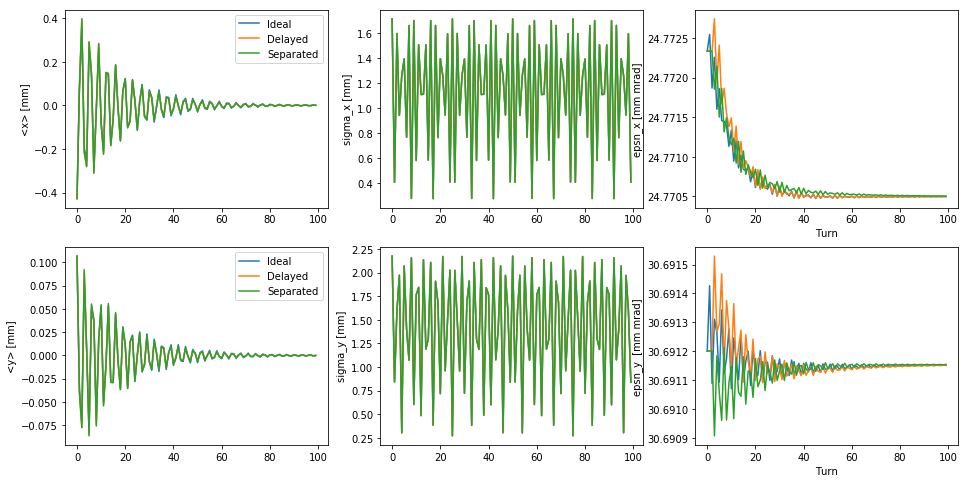

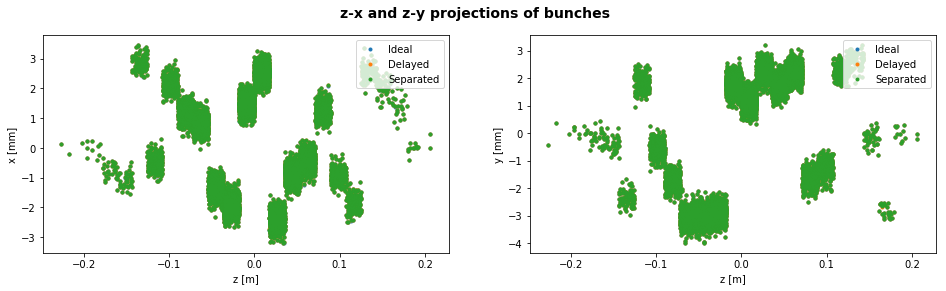

In [10]:
# In here, the traces and the projections from different implementations of the feedback system are compared.
# Note the scale in the emittance figures.

compare_traces([tracker_OneBox_bunch,tracker_register_example,tracker_separated_example],
               ['Ideal', 'Delayed', 'Separated'])
compare_projections([ bunch_OneBox_bunch,  bunch_register_example, bunch_separated_example], 
                    ['Ideal', 'Delayed', 'Separated'])

# compare_traces([tracker_OneBox_bunch,tracker_register_example,tracker_register_example2],
#                ['Ideal', 'Delayed', 'Separated'])
# compare_projections([ bunch_OneBox_bunch,  bunch_register_example,  bunch_register_example2], 
#                     ['Ideal', 'Delayed', 'Separated'])

# compare_traces([tracker_OneBox_bunch,tracker_register_example],
#                ['Ideal', 'Delayed', 'Separated'])
# compare_projections([ bunch_OneBox_bunch,  bunch_register_example], 
#                     ['Ideal', 'Delayed', 'Separated'])

Jani Komppula, CERN, 2017